# Preselect Datasets (Balance Classes)

**Description**:\
This notebook analyzes the EEG files to ensure training datasets meet requirements and have evenly distributed classes.

**Author**: Elmo Chavez\
**Date**: October 11, 2023

## Libraries

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

path_eeg_mne = os.path.abspath(os.path.join(os.path.dirname('eeg_mne.py'), '..'))
sys.path.append(path_eeg_mne)
import eeg_mne

## Read Datasets

In [2]:
path_dataset = '../ds004504/'
path_training_dataset = '../Training Dataset/'

Reading Participants Info

In [3]:
file_participants = '../ds004504/participants.tsv'
df_participants = pd.read_csv(path_dataset+file_participants, sep='\t')
df_participants.head()

,participant_id,Gender,Age,Group,MMSE
0,sub-001,F,57,A,16
1,sub-002,F,78,A,22
2,sub-003,M,70,A,14
3,sub-004,F,67,A,20
4,sub-005,M,70,A,22


Reading All EEG Raw datasets

In [4]:
path_preprocessed_eeg = '../ds004504/derivatives'
eeg_raws_data = eeg_mne.EEG_Raw_Data_List(path=path_preprocessed_eeg)

EEG Raw Data readed: 88


## Explore the Datasets

Plot the Maximum Time Recorded by Each Subject

Average Max Time: 793.53


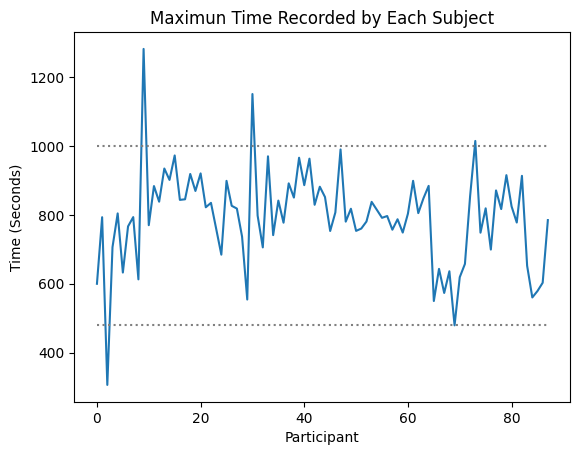

In [5]:
# Max time for each subject
time_max = [np.max(r.times) for r in eeg_raws_data]
# Add feature to DF  
df_participants['time_max'] = time_max

# Print the Average Time recorded overall the Raw Data
print('Average Max Time:', round(np.average(time_max),2))

# Plot Max Time
const_min = np.full(len(eeg_raws_data),480)
const_max = np.full(len(eeg_raws_data),1000)
plt.plot(time_max)
plt.plot(const_min, linestyle='dotted', c='gray')
plt.plot(const_max, linestyle='dotted', c='gray')
plt.title('Maximun Time Recorded by Each Subject')
plt.xlabel('Participant')
plt.ylabel('Time (Seconds)')

plt.show()

## Prepare Preselected Participants Dataset

Adding Support data to the Participants Info datasets

In [6]:
df_participants['points'] = [r.n_times for r in eeg_raws_data]
df_participants['sfreq'] = [r.info['sfreq'] for r in eeg_raws_data]

df_participants.head()

,participant_id,Gender,Age,Group,MMSE,time_max,points,sfreq
0,sub-001,F,57,A,16,599.798,299900,500.0
1,sub-002,F,78,A,22,793.098,396550,500.0
2,sub-003,M,70,A,14,306.098,153050,500.0
3,sub-004,F,67,A,20,706.098,353050,500.0
4,sub-005,M,70,A,22,804.098,402050,500.0


Encoding Gender and Group

In [7]:
Encoder_Dictionary = {
    'Gender': {'F': 0, 'M': 1},
    'Group': {'A': 0, 'F': 1, 'C': 2}
}

df_participants['Gender'] = df_participants['Gender'].replace(Encoder_Dictionary['Gender'])
df_participants['Group'] = df_participants['Group'].replace(Encoder_Dictionary['Group'])

Flag all the Participants with at least 600 seconds of EEG data recorded and make a balance for all the Classes

In [8]:
df_participants['flag'] = np.where((df_participants['time_max'] < 540) | (df_participants['Group'] == 2), False, True)

In [9]:
df_participants.head()

,participant_id,Gender,Age,Group,MMSE,time_max,points,sfreq,flag
0,sub-001,0,57,0,16,599.798,299900,500.0,True
1,sub-002,0,78,0,22,793.098,396550,500.0,True
2,sub-003,1,70,0,14,306.098,153050,500.0,False
3,sub-004,0,67,0,20,706.098,353050,500.0,True
4,sub-005,1,70,0,22,804.098,402050,500.0,True


In [10]:
df_participants.groupby(['Group','flag'])['participant_id'].count()

Group  flag 
0      False     1
       True     35
1      False     1
       True     22
2      False    29
Name: participant_id, dtype: int64

Make the Dataset Balanced with Group 0 and 1

In [11]:
condition = df_participants['Group']==0
filtered = df_participants[condition].tail(13)
filtered['flag'] = False
df_participants.update(filtered)

In [12]:
df_participants.groupby(['Group','flag'])['participant_id'].count()

Group  flag 
0      False    14
       True     22
1      False     1
       True     22
2      False    29
Name: participant_id, dtype: int64

## Save Files

In [13]:
filename_dict = 'Encoder_Dictionary.json'
pretty_json = json.dumps(Encoder_Dictionary, indent=4)

with open(path_training_dataset+filename_dict, 'w') as json_file:
    json_file.write(pretty_json)

In [14]:
filename_part_selected = 'Participants_Selected.csv'
df_participants.to_csv(path_training_dataset+filename_part_selected, index=False)